# Cross Validation: A Worked Example

Here, I motivate cross validation (e.g., Stone, 1974; Allen, 1974; Stone, 1977) as a means for model comparison using a simple worked example. While this technique has been widely used in the machine learning and statistics communities for 40 years, I have not seen it implemented in the astronomy literature outside of brief mentions in papers that explicitly leverage machine learning techniques. Because cross validation is the focus of Chapter 4, I present the technique here so as to disentangle the perhaps unfamiliar statistics from the complicating discussion of the *Fermi* Science Tools software.

I create a simulated data set in which the independent variable is drawn randomly from the interval [-1,1), and the dependent variable is drawn from a tenth order Legendre polynomial $P_{10}(x)$ with Gaussian deviates. I then perform ordinary least squares fits (OLS) using polynomial feature sets of various degrees. I show that cross validation is able to establish a polynomial of degree ten best fits the simulated data, and that OLS is able to accurately determine the coefficients of $P_{10}(x)$.

##Imports

In [1]:
%matplotlib inline

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

##Simulated Function

I use the $P_{10}(x)$ Legendre polynomial to ensure the underlying function requires a decent number of parameters to model properly. Further, $P_{10}(x)$ is ideal as a tenth order polynomial because all eight of its inflection points lie within the interval [-1,1). The tenth order Legendre polynomial is given by:
$$P_{10}(x) = \frac{1}{256}\left(46189x^{10} - 109395x^8 + 90090x^6 - 30030x^4 + 3465x^2 - 63\right)$$

Below I plot the function on the interval [-1,1).

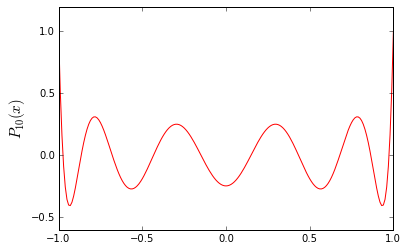

In [2]:
x_legendre = np.linspace(-1, 1, 201).reshape(201, 1)
coef = np.array([0]*10 + [1])
P_10 = np.polynomial.legendre.Legendre(coef)
plt.plot(x_legendre, P_10(x_legendre), 'r')
plt.ylabel(r'$P_{10}(x)$', size=15)
plt.show()

##Simulated data

For the purposes of this example, I introduce random Gaussian perturbations with zero mean and standard deviation of 0.1, which are meant to emulate the measurement errors associated with scientific experiments. The dependent variable is given by:
$$y = P_{10}(x) + N(\mu = 0, \sigma = 0.1)$$

Below I draw 1,000 points from this distribution and overlay them on the plot shown above.

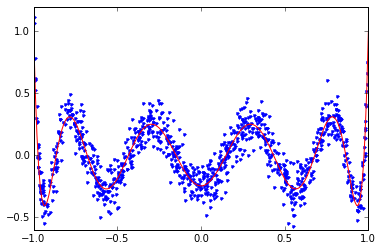

In [3]:
#Seed the random number generator
np.random.seed(1)
#1,000 random numbers between -1 and 1
x = np.random.rand(1000) * 2. - 1.
#draw from 10th order Legendre polynomial with Gaussian deviate
y = P_10(x) + np.random.randn(len(x)) * 0.1
plt.plot(x, y, '.')
plt.plot(x_legendre, P_10(x_legendre), 'r')
plt.show()

##Model pipeline

Here, I use scikit-learn's pipelining functionality to construct various polynomial feature sets to be fed to the OLS model (called Linear Regression by scikit-learn). By chaining together the scikit-learn functions in this way, we can use cross validation to determine the optimal number of polynomial features to include in our model. Given that our data is sampled from a polynomial of degree ten, we should expect cross validation to recommend we use features up to $x^{10}$.

In [4]:
poly_features = PolynomialFeatures()
#bias term is included in polynomial feature set
linear_regression = LinearRegression(fit_intercept=False)
poly_pipe = Pipeline([('poly_features', poly_features),
                      ('linear_regression', linear_regression)])

##Grid Search

Scikit-learn's grid search functionality allows the user to test a grid of model hyperparameters (in our case, degree of polynomial) and optimizes using cross validation and a specified scoring technique. Here I have elected to use five fold cross validation (`cv=5`) so that each data point is grouped randomly into one of five subsets, 
$$S_i;\ i \in [0,4],$$
such that each subset contains 200 points. Each subset is then used once as a testing set and four times in training over the five folds:
* Fold 0: Test Set = $S_0$; Training Set = $S_1 \cup S_2 \cup S_3 \cup S_4$
* Fold 1: Test Set = $S_1$; Training Set = $S_0 \cup S_2 \cup S_3 \cup S_4$
* Fold 2: Test Set = $S_2$; Training Set = $S_0 \cup S_1 \cup S_3 \cup S_4$
* Fold 3: Test Set = $S_3$; Training Set = $S_0 \cup S_1 \cup S_2 \cup S_4$
* Fold 4: Test Set = $S_4$; Training Set = $S_0 \cup S_1 \cup S_2 \cup S_3$

The statistic I have used for scoring is the opposite of the mean absolute error:
$$-\frac{1}{N}\sum_{j=1}^{N}\left|y_j - y_{\rm pred}(x_j)\right|.$$
The negative sign is introduced because scikit-learn uses *maximization* to determine the optimal hyperparameter set. While here we wish to minimize error, other users wish to maximize $R^2$ or maximize accuracy in a classification problem. This is simply the scikit-learn convention.

I compare models with polynomials of degree 1, 3, 8, 9, 10, 11, 12, 30, and 100. We can see below that cross validation is able to determine that `degree=10` is the optimal parameter choice for the polynomial feature set.

In [5]:
param_grid = {'poly_features__degree': [1, 3, 8, 9, 10, 11, 12, 30,
                                        100]}
grid_search = GridSearchCV(estimator=poly_pipe,
                           param_grid=param_grid,
                           scoring='mean_absolute_error', cv=5)
grid_search.fit(x.reshape(len(x), 1), y)
print(grid_search.best_params_)

{'poly_features__degree': 10}


The fact that scikit-learn allows for the implementation of this powerful machinery with the requirement of only few lines of python code demonstrates the importance and broad adoption of cross validation as a means for distinguishing between models.

##Results

Below I tabulate and plot the mean absolute error computed for each polynomial feature set across all five cross validation folds. We can see a significant improvement in the error once the polynomial degree is high enough to account for the eight inflection points in the simulated data. I have made a second plot where I only show polynomial feature sets of degree > 9 for easier inspection of the error quantities across the folds.

Across the five folds, degree ten does not always minimize the mean absolute error. The data is split in folds zero and two such that the error is minimized when the degree is 11. In all the other folds, degree ten does minimize the error, and so the grid search selects ten as the optimal hyperparameter value. This demonstrates the value of creating an ensemble of test and training sets.

          1         3         8         9        10        11        12  \
0  0.203547  0.204304  0.203873  0.203536  0.071582  0.071538  0.071560   
1  0.200412  0.200495  0.198518  0.199023  0.078715  0.078878  0.079103   
2  0.194154  0.194247  0.191175  0.190927  0.078782  0.078715  0.078760   
3  0.204298  0.204485  0.203822  0.203625  0.087778  0.087789  0.087784   
4  0.195346  0.196047  0.197285  0.199298  0.090653  0.090753  0.090763   

         30       100  
0  0.074741  0.075394  
1  0.080088  0.083067  
2  0.078967  0.079752  
3  0.088378  0.089906  
4  0.091950  0.095221  


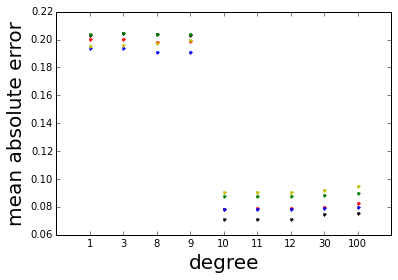

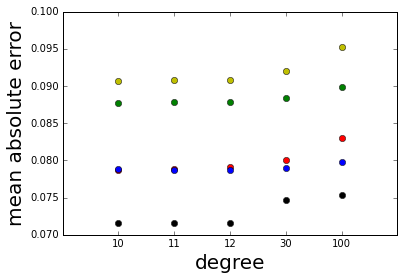

In [6]:
grid_scores = grid_search.grid_scores_
degree = []
scores = []
for i in xrange(len(grid_scores)):
    degree.append(str(grid_scores[i][0]['poly_features__degree']))
    scores.append(-grid_scores[i][2])
scores = np.array(scores)

print(pd.DataFrame(scores.T, columns=degree))

plt.plot(range(9), scores[:,0], 'k.')
plt.plot(range(9), scores[:,1], 'r.')
plt.plot(range(9), scores[:,2], 'b.')
plt.plot(range(9), scores[:,3], 'g.')
plt.plot(range(9), scores[:,4], 'y.')
plt.xlim(xmin=-1, xmax=9)
plt.xticks(range(9), degree)
plt.xlabel('degree', size=20)
plt.ylabel('mean absolute error', size=20)
plt.show()
plt.clf()

plt.plot(range(5), scores[:,0][4:], 'ko')
plt.plot(range(5), scores[:,1][4:], 'ro')
plt.plot(range(5), scores[:,2][4:], 'bo')
plt.plot(range(5), scores[:,3][4:], 'go')
plt.plot(range(5), scores[:,4][4:], 'yo')
plt.xlim(xmin=-1, xmax=5)
plt.xticks(range(5), degree[4:])
plt.xlabel('degree', size=20)
plt.ylabel('mean absolute error', size=20)
plt.show()

##Coefficients

Below I tabulate the actual coefficients of the tenth order Legendre polynomial and the coefficients determined from the simulated data set. I also plot $P_{10}(x)$ and the function determined by linear regression. We see very little difference between the true and fitted functions, which is especially apparent in the plot.

          P_10      y_pred  |P_10 - y_pred|
0    -0.246094   -0.250986         0.004892
1     0.000000    0.016836         0.016836
2    13.535156   13.738934         0.203778
3     0.000000   -0.299105         0.299105
4  -117.304688 -118.976626         1.671938
5     0.000000    1.431107         1.431107
6   351.914062  357.100841         5.186778
7     0.000000   -2.333031         2.333031
8  -427.324219 -433.855783         6.531564
9     0.000000    1.202340         1.202340
10  180.425781  183.295822         2.870041


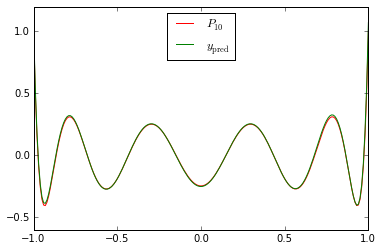

In [7]:
P_10_coef = np.array([-63., 0., 3465., 0., -30030., 0., 90090., 0.,
                      -109395., 0., 46189.]) / 256.
best_estimator = grid_search.best_estimator_
y_pred_coef = best_estimator.named_steps['linear_regression'].coef_
diff = np.abs(P_10_coef - y_pred_coef)
df = pd.DataFrame(pd.Series(P_10_coef), columns=['P_10'])
df['y_pred'] = pd.Series(y_pred_coef)
df['|P_10 - y_pred|'] = pd.Series(diff)
print(df)

plt.plot(x_legendre, P_10(x_legendre), 'r', label=r'$P_{10}$')
plt.plot(x_legendre, best_estimator.predict(x_legendre), 'g',
         label=r'$y_{\rm pred}$')
plt.legend(loc='upper center')
plt.show()

##Conclusions

While I have not shown it here, the addition of free parameters will always reduce error with respect to the data on which the model was trained, otherwise, those parameters should be set to zero. This fact motivates the holding out of testing data against which models are not trained so that predictive power may be appropriately be measured. Cross validation has the added benefit of an ensemble of training and testing sets, which allows for a statistical assessment of the error quantities when determining the best fit model.